In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [25]:
df = pd.read_csv('Zenkart_Dataset.csv')
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [26]:
for col in ['Income', 'DeliveryTime', 'Rating']:
    df[col].fillna(df[col].median(), inplace=True)

for col in ['Price', 'CLV', 'DeliveryTime']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

/tmp/ipython-input-4200424052.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [27]:
customer_df = df[['CustomerID', 'Age', 'CityTier', 'Income', 'TotalOrders', 'CLV']].drop_duplicates('CustomerID')

In [28]:
features = customer_df[['Age', 'CityTier', 'Income', 'TotalOrders', 'CLV']].dropna()
customer_df = customer_df.loc[features.index]

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [30]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

In [31]:
df = df.merge(customer_df[['CustomerID', 'Cluster']], on='CustomerID', how='left')

In [37]:
clf_df = df[['CustomerID', 'Age', 'CityTier', 'Income', 'TotalOrders', 'CLV', 'Churn', 'Cluster']].drop_duplicates('CustomerID')
X = clf_df[['Age', 'CityTier', 'Income', 'TotalOrders', 'CLV', 'Cluster']]
y = clf_df['Churn']
X = X.dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [39]:
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        64
           1       0.71      0.29      0.42        17

    accuracy                           0.83        81
   macro avg       0.78      0.63      0.66        81
weighted avg       0.81      0.83      0.80        81

Confusion Matrix:
 [[62  2]
 [12  5]]


In [40]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.93      0.82      0.88        17

    accuracy                           0.95        81
   macro avg       0.94      0.90      0.92        81
weighted avg       0.95      0.95      0.95        81

Confusion Matrix:
 [[63  1]
 [ 3 14]]


In [41]:
df['Sales'] = df['Price'] * df['Quantity']

df_ts = df.set_index('OrderDate').sort_index()
weekly_sales = df_ts['Sales'].resample('W').sum()
weekly_sales = weekly_sales.asfreq('W').interpolate(method='linear')
Q1 = weekly_sales.quantile(0.25)
Q3 = weekly_sales.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
weekly_sales = np.clip(weekly_sales, lower, upper)


In [42]:
model = ARIMA(weekly_sales, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

forecast_index = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W')


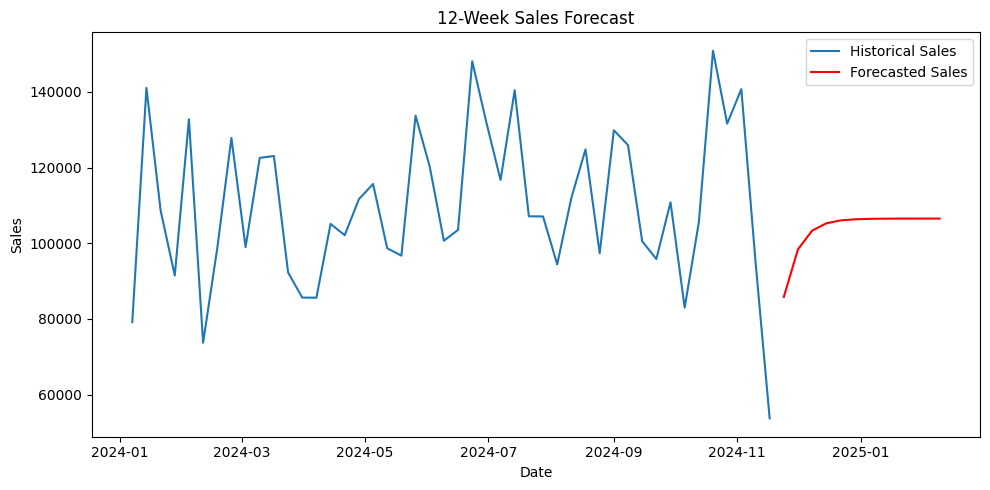

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales.index, weekly_sales, label='Historical Sales')
plt.plot(forecast_index, forecast, label='Forecasted Sales', color='red')
plt.title('12-Week Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

Distribution Plots Before and After Outlier Treatment


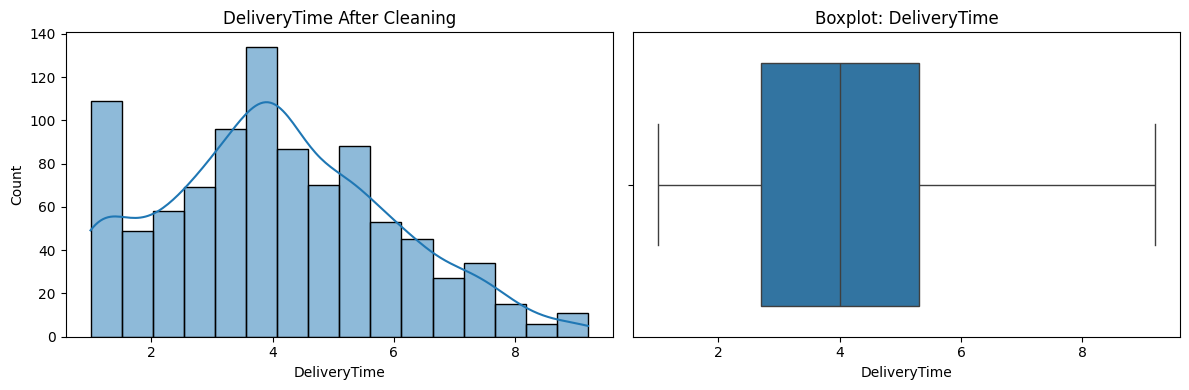

In [45]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['DeliveryTime'], kde=True, ax=axes[0])
axes[0].set_title('DeliveryTime After Cleaning')
sns.boxplot(x=df['DeliveryTime'], ax=axes[1])
axes[1].set_title('Boxplot: DeliveryTime')
plt.tight_layout()
plt.show()


Customer Segmentation Cluster Plot (2D Projection)

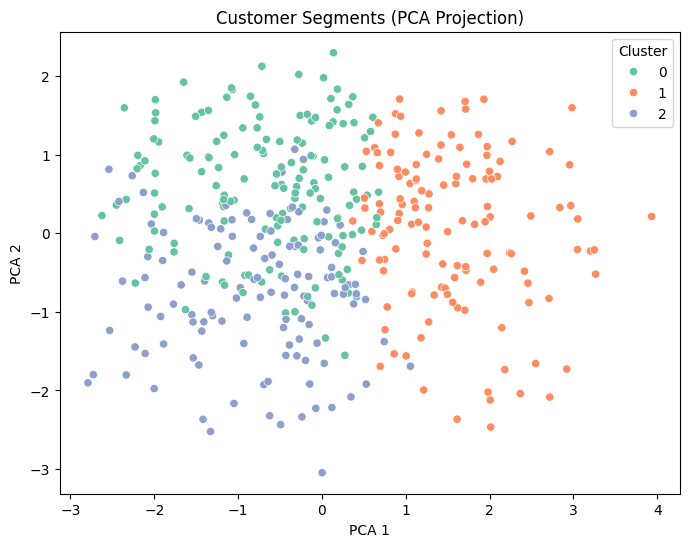

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_df['Cluster'], palette='Set2')
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()


Churn vs Non-Churn Comparison by CLV and Total Orders

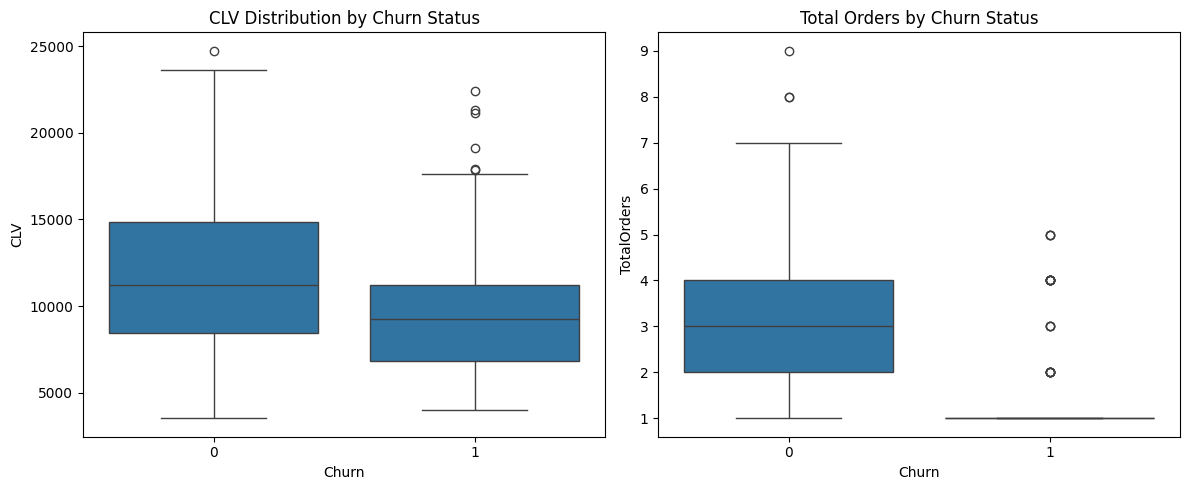

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Churn', y='CLV', data=clf_df)
plt.title('CLV Distribution by Churn Status')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn', y='TotalOrders', data=clf_df)
plt.title('Total Orders by Churn Status')

plt.tight_layout()
plt.show()


Sales Trend With Moving Average

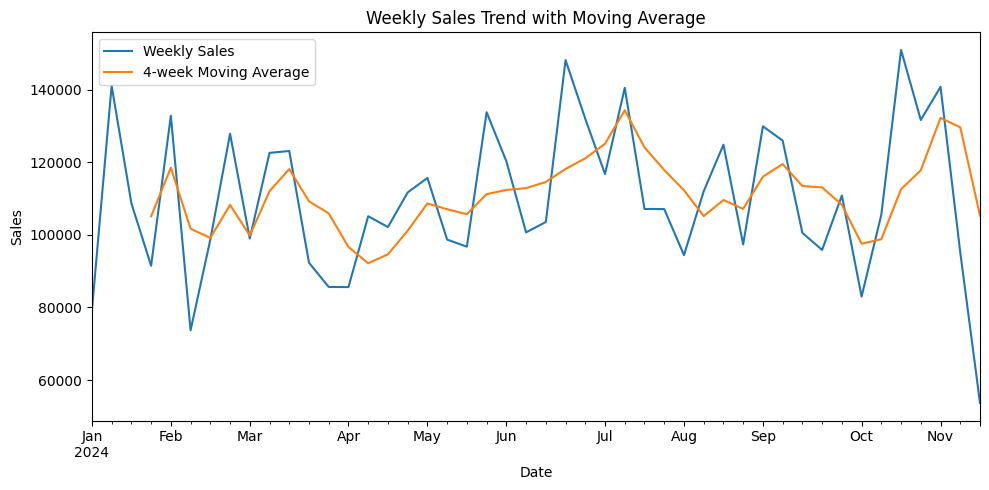

In [48]:
plt.figure(figsize=(10, 5))
weekly_sales.plot(label='Weekly Sales')
weekly_sales.rolling(window=4).mean().plot(label='4-week Moving Average')
plt.title('Weekly Sales Trend with Moving Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


Feature Importance from Random Forest

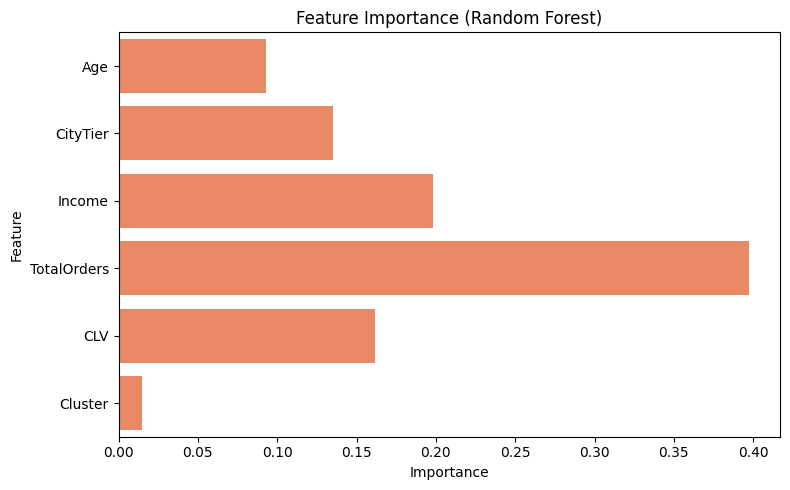

In [70]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, color='coral')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Exploratory Data Analysis (EDA)


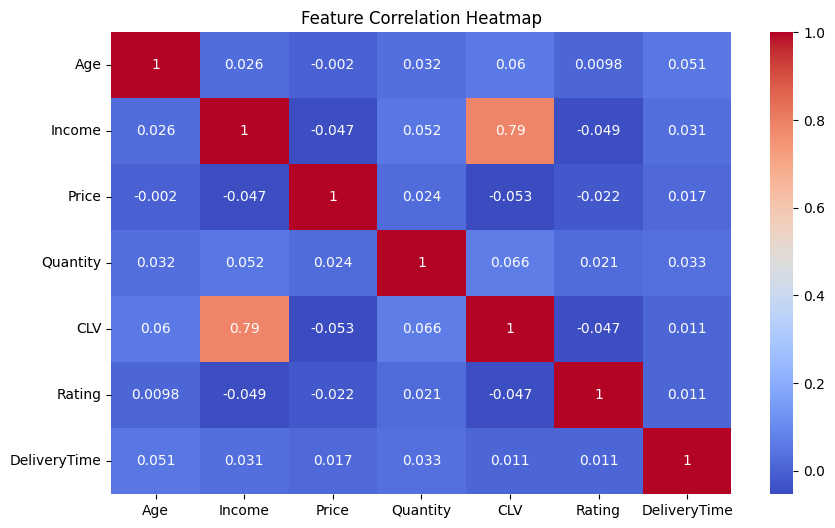

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Age', 'Income', 'Price', 'Quantity', 'CLV', 'Rating', 'DeliveryTime']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


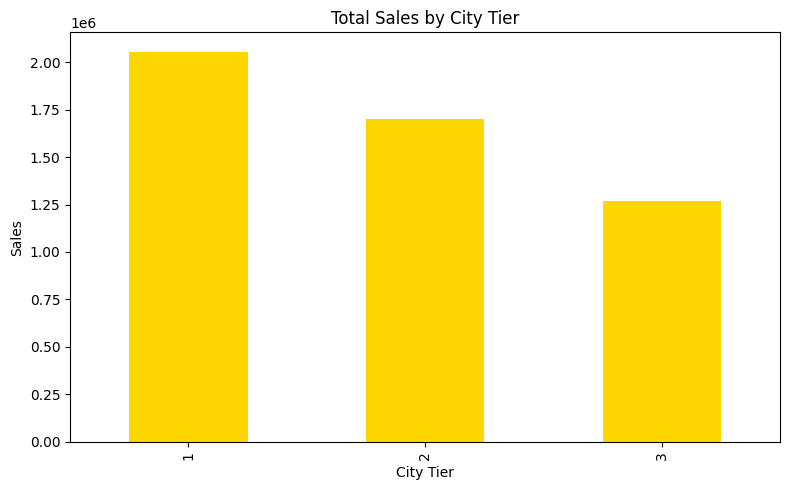

In [79]:
tier_sales.plot(
    kind='bar',
    figsize=(8, 5),
    title='Total Sales by City Tier',
    color='gold'
)
plt.ylabel('Sales')
plt.xlabel('City Tier')
plt.tight_layout()
plt.show()


#tier 1: metro, tier 2: semi-urban, tier 3: rural

Sales Seasonality & Patterns

/tmp/ipython-input-2096507619.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_ts['Sales'].resample('M').sum()


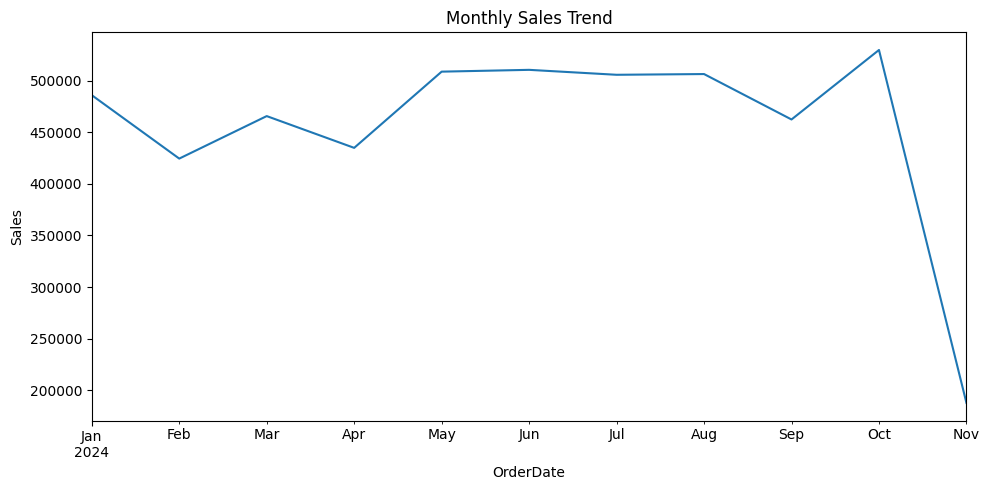

In [63]:
monthly_sales = df_ts['Sales'].resample('M').sum()
monthly_sales.plot(title='Monthly Sales Trend', figsize=(10, 5))
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


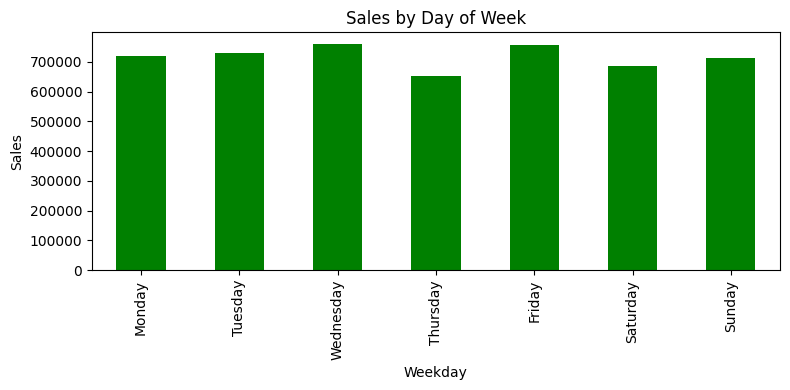

In [78]:
df['Weekday'] = df['OrderDate'].dt.day_name()
weekday_sales = df.groupby('Weekday')['Sales'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
weekday_sales.plot(kind='bar', title='Sales by Day of Week', ylabel='Sales', color = 'green',figsize=(8,4))
plt.tight_layout()
plt.show()
